In [1]:
import matplotlib.pyplot as plt
import gensim
import numpy as np
import pandas as pd
import spacy

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import os, re, operator, warnings
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now
%matplotlib inline

In [2]:
df = pd.read_csv("./data/reddit/cm/askanincel_comments.csv")

In [3]:
sdf = pd.read_csv('subreddits.csv')
subreddits = sdf.values.tolist()

for s in subreddits:
    sub = str(s)[5:-5]
    print('sub', sub)     

    temp_df = pd.read_csv(f'./data/reddit/cm/{sub}_comments.csv')
    temp_serie = temp_df.Comment
    if s == subreddits[0]:
        serie = temp_serie
    else:
        serie = serie.append(temp_serie, ignore_index=True)

In [4]:
serie = df.Comment

In [5]:
serie.head()

0                               Larpers/satire/parody.
1    You should realise that at least a third of th...
2           Why would you ask this question to incels?
3    Men have a broader range of attraction. \n\nA ...
4    Would never date one. And they would never dat...
Name: Comment, dtype: object

In [6]:
serie.shape

(41127,)

In [7]:
serie = serie[serie != '[deleted]']

In [8]:
serie.shape

(41118,)

serie.to_csv("./data/reddit/cm/all_comments.csv")

## Pre-processing data

In [9]:
nlp = spacy.load("en")

In [10]:
my_stop_words = [u'say', u'\s', u'Mr', u'be', u'said', u'says', u'saying', u's', u'’s', u'\n\n']
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [11]:
stl= pd.Series.tolist(serie)

In [14]:
texts, article, skl_texts = [], [], []
for comment in stl:
    try:
        doc = nlp(comment)
    except:
        continue
    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article!
        if not w.is_stop and not w.is_punct and not w.like_num:
            # we add the lematized version of the word
            article.append(w.lemma_)
        # assume each comment as a document
        if w.text == doc[-1].text:
            skl_texts.append(' '.join(article))
            texts.append(article)
            article = []

In [15]:
texts

[['larper', 'satire', 'parody'],
 ['realise', 'woman', 'genuinely', 'think', 'femcel', 'thing'],
 ['lay', 'hot', 'guy', 'hold', 'start', 'parody', 'frequency', 'user'],
 ['ask', 'question', 'incel'],
 ['man', 'broad', 'range', 'attraction'],
 ['guy',
  'fat',
  'short',
  'ugly',
  'asian',
  'Indian',
  'immediately',
  'find',
  'sizeable',
  'majority',
  'woman',
  'immediately',
  'turn'],
 ['basically', 'exist', 'woman', 'case'],
 ['date'],
 ['date'],
 ['acknowledge', 'existence'],
 ['call', 'ask', 'incel'],
 ['go'],
 ['conceive',
  'big',
  'disadvantage',
  'burden',
  'pregnancy',
  'birth',
  'grant',
  'fuckton',
  'hidden',
  'advantage',
  'core',
  'woman',
  'view',
  'inherently',
  'valuable'],
 ['man', 'expendable', 'history'],
 ['yes'],
 ['think',
  'answer',
  'question',
  'theoretically',
  'speak',
  'man',
  'woman',
  'enjoy',
  'sex'],
 ['second',
  'question',
  'enjoy',
  'sex',
  'entirely',
  'dependent',
  'attractiveness',
  'partner'],
 ['date'],
 ['goo

In [16]:
file = pd.Series(texts)
file.to_csv("texts.csv")

In [17]:
bigram = gensim.models.Phrases(texts)

In [18]:
texts = [bigram[line] for line in texts]

In [19]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [20]:
corpus[5][0:10]

[(8, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 2),
 (27, 1),
 (28, 1),
 (29, 1)]

## LSI

In [21]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [22]:
lsimodel.show_topics()  

[(0,
  '0.581*"woman" + 0.321*"man" + 0.269*"like" + 0.246*"incel" + 0.239*" " + 0.181*"people" + 0.167*"not" + 0.152*"think" + 0.148*"want" + 0.126*"look"'),
 (1,
  '-0.629*"woman" + 0.335*"incel" + -0.334*"man" + 0.288*"like" + 0.273*"people" + 0.204*"not" + 0.198*" " + 0.144*"think" + 0.114*"know" + 0.091*"want"'),
 (2,
  '0.737*"incel" + -0.531*" " + -0.278*"like" + 0.189*"not" + -0.108*"people" + 0.066*"woman" + -0.054*"thing" + -0.053*"good" + -0.051*"feel" + -0.050*"guy"'),
 (3,
  '0.615*" " + -0.502*"not" + 0.432*"incel" + -0.329*"like" + -0.131*"be" + -0.082*"\n" + -0.077*"look" + -0.067*"know" + -0.063*"people" + -0.058*"girl"'),
 (4,
  '-0.736*"like" + 0.425*"not" + 0.213*"man" + -0.202*"incel" + 0.201*" " + 0.186*"people" + -0.154*"woman" + 0.121*"want" + 0.116*"think" + 0.092*"know"'),
 (5,
  '0.786*"man" + -0.439*"woman" + -0.299*"people" + 0.196*"like" + 0.103*"incel" + 0.098*"female" + -0.078*"want" + -0.077*"think" + 0.076*" " + -0.059*"guy"'),
 (6,
  '0.572*"people" +

## HDP

In [23]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [24]:
hdpmodel.show_topics()

[(0,
  '0.022*woman + 0.014*like + 0.013*incel + 0.013*man + 0.011*people + 0.010*not + 0.009*want + 0.009*think + 0.008*  + 0.007*know + 0.007*look + 0.006*guy + 0.006*thing + 0.005*girl + 0.005*good + 0.005*\n + 0.005*way + 0.005*try + 0.005*be + 0.005*get'),
 (1,
  '0.006*woman + 0.004*like + 0.004*incel + 0.003*man + 0.003*people + 0.003*not + 0.003*think + 0.002*want + 0.002*know + 0.002*thing + 0.002*look + 0.002*  + 0.002*try + 0.002*guy + 0.001*girl + 0.001*be + 0.001*life + 0.001*good + 0.001*fuck + 0.001*\n'),
 (2,
  '0.005*woman + 0.004*like + 0.004*incel + 0.003*man + 0.003*people + 0.003*not + 0.003*think + 0.002*want + 0.002*know + 0.002*look + 0.002*  + 0.002*\n + 0.002*thing + 0.002*guy + 0.002*good + 0.001*fuck + 0.001*go + 0.001*girl + 0.001*get + 0.001*try'),
 (3,
  '0.005*woman + 0.004*like + 0.003*incel + 0.003*man + 0.003*people + 0.003*think + 0.003*not + 0.002*want + 0.002*know + 0.002*look + 0.002*  + 0.002*guy + 0.001*girl + 0.001*thing + 0.001*good + 0.001*\n

## LDA

In [25]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [26]:
ldamodel.show_topics()

[(0,
  '0.033*"post" + 0.030*"incel" + 0.018*"literally" + 0.017*"question" + 0.016*"answer" + 0.015*"comment" + 0.015*"sure" + 0.015*"rape" + 0.015*"shit" + 0.014*"happen"'),
 (1,
  '0.068*"woman" + 0.037*"man" + 0.031*"mean" + 0.021*"incel" + 0.016*"like" + 0.014*"think" + 0.013*"stop" + 0.012*"consider" + 0.011*"date" + 0.011*"experience"'),
 (2,
  '0.111*"incel" + 0.084*"want" + 0.042*"sex" + 0.041*"not" + 0.017*"femcel" + 0.017*"true" + 0.012*"female" + 0.012*"exist" + 0.012*"money" + 0.010*"know"'),
 (3,
  '0.022*"woman" + 0.017*"people" + 0.015*"world" + 0.015*"human" + 0.013*"life" + 0.011*"issue" + 0.011*"social" + 0.010*"like" + 0.009*"bad" + 0.008*"fact"'),
 (4,
  '0.030*"people" + 0.028*"work" + 0.021*"be" + 0.019*"understand" + 0.018*"try" + 0.018*"life" + 0.017*" " + 0.013*"think" + 0.012*"amp#x200B" + 0.012*"woman"'),
 (5,
  '0.033*"care" + 0.031*"guy" + 0.027*"lol" + 0.023*"start" + 0.022*"girl" + 0.017*"gay" + 0.016*"lie" + 0.015*"like" + 0.010*"honestly" + 0.010*"watc

## pyLDAvis

In [27]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.103427 -0.047382       1        1  12.954256
8     -0.096135 -0.069150       2        1  12.178949
9     -0.117610  0.072182       3        1  12.031288
6     -0.056883 -0.032382       4        1  11.478769
4     -0.110870 -0.065940       5        1  11.341928
3     -0.126099 -0.063800       6        1   9.548295
2      0.171725 -0.206396       7        1   8.605042
0      0.276202 -0.032582       8        1   7.490308
5     -0.002617  0.294843       9        1   7.271280
7      0.165713  0.150606      10        1   7.099876, topic_info=     Category          Freq        Term         Total  loglift  logprob
16    Default   8883.000000       incel   8883.000000  30.0000  30.0000
135   Default   5838.000000        want   5838.000000  29.0000  29.0000
8     Default  13038.000000       woman  13038.000000  28.0000  28.0000
125   Default   4610.000000        look   4610.000000  27.0000  27.0000
58    Default   3175.000000         sex   3175.000000  26.0000  26.0000
19    Default   7572.000000         man   7572.000000  25.0000  25.0000
68    Default   3199.000000        fuck   3199.000000  24.0000  24.0000
271   Default   2544.000000        mean   2544.000000  23.0000  23.0000
696   Default   2200.000000      friend   2200.000000  22.0000  22.0000
100   Default   5114.000000         not   5114.000000  21.0000  21.0000
1052  Default   1929.000000        work   1929.000000  20.0000  20.0000
192   Default   2549.000000          \n   2549.000000  19.0000  19.0000
25    Default   3661.000000         guy   3661.000000  18.0000  18.0000
127   Default   1442.000000        care   1442.000000  17.0000  17.0000
258   Default   1552.000000        post   1552.000000  16.0000  16.0000
55    Default   1705.000000         yes   1705.000000  15.0000  15.0000
248   Default   4895.000000        know   4895.000000  14.0000  14.0000
110   Default   1190.000000         lol   1190.000000  13.0000  13.0000
545   Default   2417.000000        hate   2417.000000  12.0000  12.0000
6     Default   3815.000000       thing   3815.000000  11.0000  11.0000
355   Default   1357.000000        help   1357.000000  10.0000  10.0000
13    Default   1008.000000       start   1008.000000   9.0000   9.0000
129   Default   1612.000000        love   1612.000000   8.0000   8.0000
178   Default   3043.000000        girl   3043.000000   7.0000   7.0000
88    Default   1423.000000  understand   1423.000000   6.0000   6.0000
855   Default    901.000000        cope    901.000000   5.0000   5.0000
850   Default   2422.000000        feel   2422.000000   4.0000   4.0000
128   Default   9050.000000        like   9050.000000   3.0000   3.0000
250   Default   1075.000000        yeah   1075.000000   2.0000   2.0000
857   Default   1155.000000        chad   1155.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
591   Topic10    318.000031         tbh    321.106018   2.6354  -4.8936
102   Topic10    386.060211      retard    390.638733   2.6333  -4.6997
275   Topic10    334.702454         eye    339.074280   2.6321  -4.8425
525   Topic10    575.165405         old    586.361389   2.6258  -4.3010
874   Topic10    201.001328         sit    203.284439   2.6338  -5.3524
204   Topic10    236.022812      settle    239.098190   2.6321  -5.1918
797   Topic10    279.140900     explain    285.866821   2.6213  -5.0240
217   Topic10    458.245880      stupid    484.359131   2.5897  -4.5283
594   Topic10    264.724731        hand    275.624359   2.6047  -5.0770
1151  Topic10    598.236694       leave    651.523499   2.5598  -4.2617
1527  Topic10    327.279358        okay    361.531647   2.5456  -4.8649
2528  Topic10    218.462372        keep    229.157623   2.5973  -5.2691
368   Topic10    317.977570      insult    364.336884   2.5090  -4.8937
349   Topic10    240.854279    pathetic    270.397217   2.5294  -5.17

## Topic Coherence

In [28]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [29]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

In [30]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

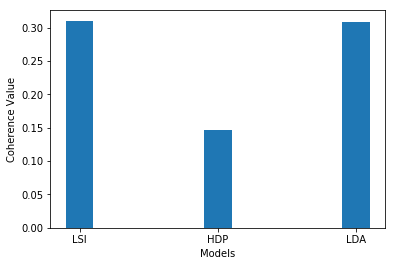

In [31]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence],
                   ['LSI', 'HDP', 'LDA'])